## Conexión a la base de datos

In [2]:
from dotenv import load_dotenv
import os

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Obtener las variables de entorno
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

In [3]:
import os
import pandas as pd
import psycopg2
from psycopg2 import sql
from dotenv import load_dotenv

def ejecutar_consulta(query, table_name):
    """
    Ejecuta una consulta SQL en la tabla especificada y devuelve un DataFrame de pandas.

    Parámetros:
    - query: str, consulta SQL con un marcador de posición para el nombre de la tabla.
    - table_name: str, nombre de la tabla a consultar.

    Retorna:
    - DataFrame de pandas con los resultados de la consulta.
    """
    # Cargar las variables de entorno desde el archivo .env
    load_dotenv()

    # Obtener las variables de entorno
    db_name = os.getenv('DB_NAME')
    db_user = os.getenv('DB_USER')
    db_password = os.getenv('DB_PASSWORD')
    db_host = os.getenv('DB_HOST')
    db_port = os.getenv('DB_PORT')

    try:
        # Establecer la conexión
        conexion = psycopg2.connect(
            dbname=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port
        )
        print("Conexión exitosa a la base de datos")

        # Crear un cursor
        cursor = conexion.cursor()

        # Formatear la consulta con el nombre de la tabla
        consulta_formateada = sql.SQL(query).format(
            table=sql.Identifier(table_name)
        )

        # Ejecutar la consulta
        cursor.execute(consulta_formateada)

        # Obtener los nombres de las columnas
        nombres_columnas = [desc[0] for desc in cursor.description]

        # Cargar los resultados en un DataFrame de pandas
        df = pd.DataFrame(cursor.fetchall(), columns=nombres_columnas)

        # Establecer una columna como índice (opcional, aquí se asume que hay una columna 'id')
        if 'id' in df.columns:
            df.set_index('id', inplace=True)

        # Cerrar el cursor y la conexión
        cursor.close()
        conexion.close()
        print("Conexión cerrada")

        return df

    except psycopg2.Error as e:
        print(f"Error en la conexión o durante la ejecución de la consulta: {e}")
        return None


In [4]:
consulta = "SELECT created_at, phone_id, origin, type_message, message  FROM {table} ORDER BY created_at DESC LIMIT 1000"
nombre_tabla = "message whatsapp"

df_resultado = ejecutar_consulta(consulta, nombre_tabla)

df_resultado

Conexión exitosa a la base de datos
Conexión cerrada


,created_at,phone_id,origin,type_message,message
0,2025-01-27 12:50:32.406076+00:00,12202,client,text,Mi pregunta es si algo d e loq ue está comiend...
1,2025-01-27 12:50:14.528315+00:00,12202,client,text,Y en la parte interna?
2,2025-01-27 12:48:33.584103+00:00,9814,agent,text,tambien se la puedes dar
3,2025-01-27 12:48:20.057357+00:00,9814,client,text,Avena?
4,2025-01-27 12:44:50.854749+00:00,6744,agent,text,tienes alguna otra duda?
...,...,...,...,...,...
995,2025-01-27 03:10:40.608339+00:00,11171,client,text,Que tal salen estas gotas?
996,2025-01-27 03:10:31.090649+00:00,11171,client,text,Le hecho una gotica que se llama Humenas
997,2025-01-27 03:10:17.142003+00:00,11171,client,text,Una consulta
998,2025-01-27 03:10:14.233836+00:00,11171,agent,event,{Docochat} ha asignado esta conversación a {Juan}


## Preprocesamiento

La idea es tomar conversación por conversación y determinar si se habla de fiebre. Lo primero es tomar un número determinado de conversaciones con más de 50 mensajes, y determinar si se habla de fiebre.

Para ello, se tomará en cuenta las palabras que se relacionan con fiebre y se buscará en cada conversación si se mencionan estas palabras.

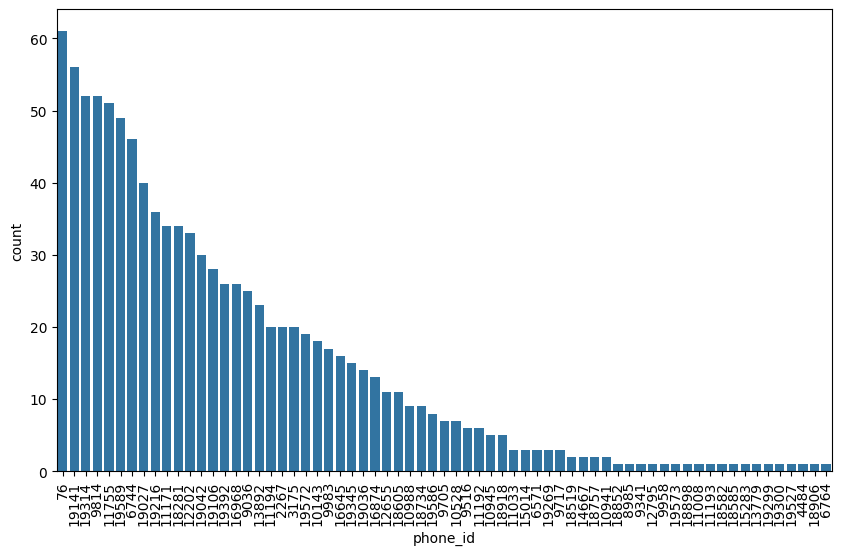

In [5]:
# Mirar cuantos phone_id hay en una distribución 
# grafico de la distribución de los phone_id
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df_resultado, x='phone_id', order=df_resultado['phone_id'].value_counts().index)
plt.xticks(rotation=90)
plt.show()


- 62 phone_id en una muestra de 1000 filas, hace referencia a 62 conversaciones diferentes. 
- Hay que tener en cuenta cómo se piensa separar las conversaciones y determinar que no sean conversaciones muy similares, se puede usar distancia coseno para determinar la similitud entre conversaciones.
- A partir de esto creemos una consulta que permita obtener primero los phone_id de las conversaciones que tienen al menos 150 mensajes y luego otra consulta que permita obtener los mensajes de estas conversaciones.

In [6]:
# consulta para traer los phone_id que tengan más de 50 mensajes
consulta = """
SELECT phone_id, COUNT(*) AS cantidad_mensajes
FROM "message whatsapp"
WHERE phone_id IN (
    SELECT DISTINCT phone_id
    FROM "message whatsapp"
        WHERE message ILIKE '%fiebre%'
)
GROUP BY phone_id
HAVING COUNT(*) > 50
ORDER BY cantidad_mensajes DESC
"""
nombre_tabla = "message whatsapp"

df_phone_ids = ejecutar_consulta(consulta, nombre_tabla)
df_phone_ids

Conexión exitosa a la base de datos
Conexión cerrada


,phone_id,cantidad_mensajes
0,9824,7827
1,11275,6287
2,5610,5658
3,10218,4918
4,10156,4720
...,...,...
2554,11081,51
2555,19037,51
2556,12250,51
2557,18177,51


- Estos phone_ids perteenecen a conversaciones que tienen al menos 150 mensajes, donde alguno de estos mensajes se menciona la palabra fiebre.

In [7]:
# Hacer consulta para traer los mensajes de los phone_id seleccionados
consulta = "SELECT created_at, phone_id, origin, type_message, message  FROM {table} WHERE phone_id = 9824  ORDER BY created_at ASC"
nombre_tabla = "message whatsapp"

# Ejecutar la consulta
df_mensajes = ejecutar_consulta(consulta, nombre_tabla)
df_mensajes

Conexión exitosa a la base de datos
Conexión cerrada


,created_at,phone_id,origin,type_message,message
0,2024-05-30 15:47:16.543660+00:00,9824,agent,template,Aprende a salvar la vida de tu hij@\n\nPor ser...
1,2024-06-04 23:56:14.435900+00:00,9824,agent,template,🚨ÚLTIMAS HORAS DE ESTE BENEFICIO🚨\r\n\r\nApren...
2,2024-06-13 20:59:58.097088+00:00,9824,client,text,Hola buenas tardes
3,2024-06-13 20:59:58.185651+00:00,9824,bot,text,Te damos la bienvenida a *DocoKids* 😁 \n👩‍⚕️ T...
4,2024-06-13 21:00:07.882262+00:00,9824,client,interactive,Acepto
...,...,...,...,...,...
7822,2025-01-27 00:50:20.288885+00:00,9824,agent,text,sii osea con el pechito tapado pero en camiset...
7823,2025-01-27 00:51:52.445753+00:00,9824,client,text,Listo doc
7824,2025-01-27 01:10:55.261656+00:00,9824,agent,note,"Juan 1 año, tiene mucha tos seca desde hace 3 ..."
7825,2025-01-27 01:11:03.350356+00:00,9824,agent,event,{Laura} ha tipificado como {Enfermedad}


TODO:

Etiquetas
- 0: Se habla de fiebre pero ese no es el diagnóstico
- 1: Se habla de fiebre y ese es el diagnóstico
- -1: No se habla de fiebre

Por qué no se menciona fiebre en el resto de las 2800 conversaciones
Separar las conversaiones
Palabras claves de los pediatras que nos puedan guiar más, lineamientos, "diagnostico: "

## Extracción de conversaciones 

### Extracción 1: 
Cada conversación es el dialogó 

In [ ]:
# import pandas as pd

# def split_conversations(df):
#     conversations = []  # Lista para guardar las conversaciones separadas
#     current_conversation = []  # Lista temporal para guardar los mensajes actuales

#     for index, row in df.iterrows():
#         message = row['message']
#         if message and type(message) == str:
#             # Comprobar si el mensaje inicia una conversación
#             if '{Docochat} ha asignado esta conversación a' in message:
#                 if current_conversation:
#                     current_conversation.append(row)
#                     # Si ya hay una conversación actual, se guarda y se reinicia
#                     conversations.append(pd.DataFrame(current_conversation))
#                     current_conversation = []

#             # Agregar la fila actual a la conversación
#             current_conversation.append(row)

#             # Comprobar si el mensaje finaliza una conversación
#             if 'ha tipificado como {Cerrar}' in message:
#                 current_conversation.append(row)
#                 # Añadir mensaje de cerrar conversación
#                 conversations.append(pd.DataFrame(current_conversation))
#                 current_conversation = []

#     # Guardar la última conversación si no está vacía o si hay un nuevo inicio
#     if current_conversation:
#         conversations.append(pd.DataFrame(current_conversation))

#     return conversations

# # Aplicar la función
# conversation_list = split_conversations(df_mensajes)

# print(f"Total de conversaciones separadas: {len(conversation_list)}")


Total de conversaciones separadas: 584


## Versión 2: 24-01 de extracción ponderada y más detallada


In [9]:
import pandas as pd

def split_conversations(df):
    conversations = []  # Lista para guardar las conversaciones separadas
    current_conversation = []  # Lista temporal para guardar los mensajes actuales
    last_timestamp = None  # Para rastrear el tiempo entre mensajes

    # Definir criterios clave
    SALUDOS = ["hola", "buenos días", "buenos dias", "buenas tardes", "buenas noches", "buenas"]
    DESPEDIDAS = ["adios", "hasta luego", "nos vemos", "chao", "hasta pronto", "hasta mañana"]
    MAX_INACTIVITY_HOURS = 4 # Horas de inactividad para considerar una nueva conversación
    MIN_MESSAGES = 15 # Número mínimo de mensajes para considerar una conversación

    for index, row in df.iterrows():
        message = row['message']
        created_at = pd.to_datetime(row['created_at'])

        # Convertir mensaje a minúsculas para comparación
        message_lower = message.lower() if isinstance(message, str) else ""

        # Comprobar si el mensaje inicia una conversación
        is_new_convo = (
            '{Docochat} ha asignado esta conversación a' in message_lower or
            any(saludo in message_lower for saludo in SALUDOS) or
            (last_timestamp and (created_at - last_timestamp).total_seconds() / 3600 > MAX_INACTIVITY_HOURS)
        )

        if is_new_convo:
            if current_conversation:
                # Si la conversación actual cumple con los criterios mínimos, se guarda
                if len(current_conversation) >= MIN_MESSAGES:
                    conversations.append(pd.DataFrame(current_conversation))
                current_conversation = []

        # Agregar la fila actual a la conversación
        current_conversation.append(row)
        last_timestamp = created_at

        # Comprobar si el mensaje finaliza una conversación usando múltiples condiciones
        is_end_convo = (
            'ha tipificado como {Cerrar}' in message_lower or
            any(despedida in message_lower for despedida in DESPEDIDAS) or
            (last_timestamp and (created_at - last_timestamp).total_seconds() / 3600 > MAX_INACTIVITY_HOURS and len(current_conversation) > MIN_MESSAGES)
        )

        if is_end_convo:
            if len(current_conversation) >= MIN_MESSAGES:
                conversations.append(pd.DataFrame(current_conversation))
            current_conversation = []

    # Guardar la última conversación si cumple los criterios
    if current_conversation and len(current_conversation) >= MIN_MESSAGES:
        conversations.append(pd.DataFrame(current_conversation))

    return conversations

# Aplicar la función
conversation_list = split_conversations(df_mensajes)

# Imprimir el número de conversaciones separadas
print(f"Total de conversaciones separadas: {len(conversation_list)}")


Total de conversaciones separadas: 193


In [10]:
i = 0

In [18]:
df_conversacion_prueba = pd.DataFrame(conversation_list[i])
i+=1
df_conversacion_prueba

,created_at,phone_id,origin,type_message,message
247,2024-06-26 23:07:09.191362+00:00,9824,client,text,Doctor buenas tardes
248,2024-06-26 23:07:44.267792+00:00,9824,client,text,Es que me hicieron una terapia y me aplicaron ...
249,2024-06-26 23:07:53.461018+00:00,9824,client,text,No pasa nada? Es que solo soy tetica
250,2024-06-26 23:18:19.044629+00:00,9824,agent,text,"karen , no , no tendrias problema , es comapti..."
251,2024-06-26 23:18:59.258328+00:00,9824,client,text,Doctor mejores opciones como que?
252,2024-06-26 23:19:20.873727+00:00,9824,client,text,Es que tengo terapia otra ves el viernes
253,2024-06-26 23:22:15.413126+00:00,9824,agent,text,Karen y como es la terapia ?
254,2024-06-26 23:23:04.948275+00:00,9824,client,text,Doc es con agujas me aplican ese líquido de a ...
255,2024-06-26 23:23:15.648980+00:00,9824,client,text,Por toda el brazo y espalda un poco
256,2024-06-26 23:23:32.903549+00:00,9824,client,text,Que diaque para sacar un músculo


## Analysis of the conversations

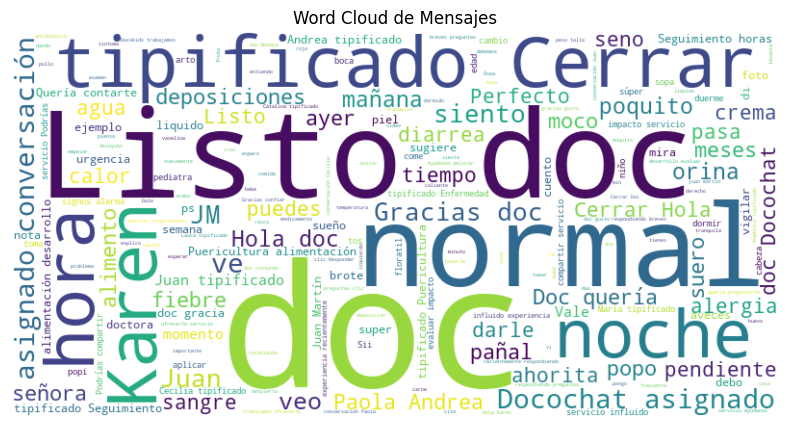

Total de conversaciones: 193
Total de mensajes en conversaciones: 5481 vs total en histórico: 7827
Palabras más frecuentes: [('doc', 1015), ('juan', 277), ('tipificado', 271), ('gracias', 236), ('listo', 231), ('karen', 202), ('conversación', 156), ('jm', 146), ('normal', 145), ('cerrar', 143)]


In [12]:
import pandas as pd
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Cargar modelo de idioma español de spaCy
nlp = spacy.load("es_core_news_sm")

def analyze_message_count(conversations):
    return [len(convo) for convo in conversations]

def compare_message_counts(conversations, df):
    conversation_count = sum(len(convo) for convo in conversations)
    total_count = len(df)
    return conversation_count, total_count

def nlp_analysis(conversations):
    all_messages = ' '.join([' '.join(convo['message'].dropna().astype(str)) for convo in conversations])
    doc = nlp(all_messages)
    word_freq = Counter([token.text.lower() for token in doc if token.is_alpha and not token.is_stop])
    return word_freq

def generate_wordcloud(conversations):
    all_text = ' '.join([' '.join(convo['message'].dropna().astype(str)) for convo in conversations])
    doc = nlp(all_text)
    words = ' '.join([token.text for token in doc if token.is_alpha and not token.is_stop])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud de Mensajes")
    plt.show()

def run_analysis_pipeline(df):
    conversation_list = split_conversations(df)
    message_counts = analyze_message_count(conversation_list)
    msg_in_convs, total_msgs = compare_message_counts(conversation_list, df)
    nlp_results = nlp_analysis(conversation_list)
    generate_wordcloud(conversation_list)

    print(f"Total de conversaciones: {len(conversation_list)}")
    print(f"Total de mensajes en conversaciones: {msg_in_convs} vs total en histórico: {total_msgs}")
    print("Palabras más frecuentes:", nlp_results.most_common(10))

# Aplicar la función
run_analysis_pipeline(df_mensajes)


## Etiquetado de conversaciones

In [10]:
def label_conversations(conversations):
    labeled_conversations = []
    fever_keywords = ['fiebre', 'temperatura', 'calentura', 'febril']  # Palabras clave para fiebre

    for conversation in conversations:
        label = -1  # Por defecto, no se habla de fiebre
        fever_detected = any(conversation['message'].str.contains('|'.join(fever_keywords), case=False, na=False))

        if fever_detected:
            label = 0  # Se habla de fiebre pero aún no es diagnóstico
            if any(
                (conversation['type_message'] == 'note') &
                (conversation['message'].str.contains('|'.join(fever_keywords), case=False, na=False))
            ):
                label = 1  # Diagnóstico de fiebre

        labeled_conversations.append((conversation, label))

    return labeled_conversations

# Aplicar la función
labeled_conversations = label_conversations(conversation_list)

# Ejemplo: Imprimir las etiquetas de las conversaciones
for i, (conversation, label) in enumerate(labeled_conversations):
    print(f"Conversación {i + 1}: Etiqueta {label}")

Conversación 1: Etiqueta -1
Conversación 2: Etiqueta -1
Conversación 3: Etiqueta 0
Conversación 4: Etiqueta -1
Conversación 5: Etiqueta 0
Conversación 6: Etiqueta -1
Conversación 7: Etiqueta -1
Conversación 8: Etiqueta -1
Conversación 9: Etiqueta -1
Conversación 10: Etiqueta -1
Conversación 11: Etiqueta -1
Conversación 12: Etiqueta -1
Conversación 13: Etiqueta -1
Conversación 14: Etiqueta -1
Conversación 15: Etiqueta -1
Conversación 16: Etiqueta -1
Conversación 17: Etiqueta -1
Conversación 18: Etiqueta -1
Conversación 19: Etiqueta -1
Conversación 20: Etiqueta -1
Conversación 21: Etiqueta -1
Conversación 22: Etiqueta -1
Conversación 23: Etiqueta -1
Conversación 24: Etiqueta -1
Conversación 25: Etiqueta -1
Conversación 26: Etiqueta -1
Conversación 27: Etiqueta -1
Conversación 28: Etiqueta -1
Conversación 29: Etiqueta -1
Conversación 30: Etiqueta -1
Conversación 31: Etiqueta -1
Conversación 32: Etiqueta -1
Conversación 33: Etiqueta -1
Conversación 34: Etiqueta -1
Conversación 35: Etiqueta

In [11]:
def analyze_labeled_conversations(labeled_conversations):
    analysis = {
        'total_conversations': len(labeled_conversations),
        'diagnosis_fever': sum(1 for _, label in labeled_conversations if label == 1),
        'mentions_fever': sum(1 for _, label in labeled_conversations if label == 0),
        'no_fever': sum(1 for _, label in labeled_conversations if label == -1)
    }

    print("Análisis de conversaciones etiquetadas:")
    print(f"Total de conversaciones: {analysis['total_conversations']}")
    print(f"Conversaciones con diagnóstico de fiebre: {analysis['diagnosis_fever']}")
    print(f"Conversaciones donde se menciona fiebre: {analysis['mentions_fever']}")
    print(f"Conversaciones sin mención de fiebre: {analysis['no_fever']}")

    return analysis

# Aplicar la función
analysis = analyze_labeled_conversations(labeled_conversations)

Análisis de conversaciones etiquetadas:
Total de conversaciones: 572
Conversaciones con diagnóstico de fiebre: 27
Conversaciones donde se menciona fiebre: 22
Conversaciones sin mención de fiebre: 523


## Automatización de la extracción y etiquetado de conversaciones

In [12]:
# Iterar sobre phone_id para extraer todas las conversaciones y guardarlas en archivos que soporten conversaciones
for phone_id in df_phone_ids['phone_id']:
    # Hacer consulta para traer los mensajes de los phone_id seleccionados
    consulta = "SELECT created_at, phone_id, origin, type_message, message  FROM {table} WHERE phone_id ="+ str(phone_id) + "ORDER BY created_at ASC"
    nombre_tabla = "message whatsapp"

    # Ejecutar la consulta
    df_mensajes = ejecutar_consulta(consulta, nombre_tabla)

    # Separar las conversaciones
    conversation_list = split_conversations(df_mensajes)

    # Etiquetar las conversaciones
    labeled_conversations = label_conversations(conversation_list)

    # Guardar las conversaciones en archivos
    for i, (conversation, label) in enumerate(labeled_conversations):
        # Crear un DataFrame con la conversación
        df_conversacion = pd.DataFrame(conversation)

        # Guardar el DataFrame en un archivo CSV
        df_conversacion.to_csv(f"conversaciones/conversacion_{phone_id}_{i}.csv", index=False)


Conexión exitosa a la base de datos
Conexión cerrada


KeyboardInterrupt: 

In [32]:
# consulta para traer los phone_id que tengan más de 50 mensajes
consulta = """
SELECT 
    phone_id,
    COUNT(*) AS total_mensajes,
    COUNT(CASE WHEN origin = 'client' THEN 1 END) AS mensajes_padre,
    COUNT(CASE WHEN origin = 'agent' THEN 1 END) AS mensajes_pediatra,
    COUNT(CASE WHEN type_message = 'note' THEN 1 END) AS total_notes,
    COUNT(CASE WHEN message ILIKE '%fiebre%' THEN 1 END) AS menciones_fiebre,
    MAX(created_at) - MIN(created_at) AS duracion_conversacion
FROM "message whatsapp"
GROUP BY phone_id
HAVING COUNT(*) < 10
ORDER BY total_mensajes ASC;

"""
nombre_tabla = "message whatsapp"

df_phone_ids = ejecutar_consulta(consulta, nombre_tabla)
df_phone_ids

Conexión exitosa a la base de datos
Conexión cerrada


,phone_id,total_mensajes,mensajes_padre,mensajes_pediatra,total_notes,menciones_fiebre,duracion_conversacion
0,16700,1,0,1,0,0,0 days 00:00:00
1,7799,1,0,1,0,0,0 days 00:00:00
2,7800,1,0,1,0,0,0 days 00:00:00
3,7801,1,0,1,0,0,0 days 00:00:00
4,7805,1,0,1,0,0,0 days 00:00:00
...,...,...,...,...,...,...,...
8901,14652,9,4,0,0,0,0 days 00:21:56.408667
8902,6416,9,1,6,1,0,300 days 21:33:17.904718
8903,6841,9,0,9,0,0,294 days 03:40:12.185005
8904,7646,9,0,2,0,0,184 days 00:12:34.927577
